# Estimation of Measurement Noise in fNIRS Channels

In [1]:
import cedalion
import cedalion.sigproc.quality as quality
import cedalion.sigproc.motion_correct as motion
import cedalion.math as math
import matplotlib.pyplot as p
import cedalion.xrutils as xrutils
import cedalion.datasets as datasets

from cedalion import units

import numpy as np
import xarray as xr

%matplotlib widget

### load data

In [2]:
# get example finger tapping dataset
rec = datasets.get_fingertapping()
#rec = datasets.get_nn22_resting_state()
#rec = datasets.get_fingertappingDOT()
rec["amp"] = quality.repair_amp(rec["amp"])
rec["od"] = cedalion.nirs.int2od(rec["amp"])

In [3]:
rec["od_corr"] = motion.tddr(rec["od"])
rec["od_corr"] = motion.wavelet(rec["od_corr"])

est_motion_sig = rec["od"]-rec["od_corr"]

In [4]:

ar_filtered_sig = math.ar_model.ar_filter(rec["od_corr"])
rec["od_clean"] = rec["od_corr"] - ar_filtered_sig


In [5]:
# motion artifacts plus AR residual
noise_total_sig = est_motion_sig + ar_filtered_sig
# motion artifacts plus AR residual, high pass filtered
noise_total_sig_hp = noise_total_sig.cd.freq_filter(fmin=0.01, fmax=0.0, butter_order=4)
# signal corrected by artifacts, high pass filtered
sig_corr_hp = rec["od_corr"].cd.freq_filter(fmin=0.01, fmax=0.0, butter_order=4)
# signal corrected by artifacts and AR resdiual, high pass filtered
sig_clean_hp = rec["od_clean"].cd.freq_filter(fmin=0.01, fmax=0.0, butter_order=4)
# AR residual highpass filtered
ar_filtered_sig_hp = ar_filtered_sig.cd.freq_filter(fmin=0.01, fmax=0.0, butter_order=4)

noise_var = noise_total_sig.var(dim="time")
noise_hp_var = noise_total_sig_hp.var(dim="time")
sig_clean_hp_var = sig_clean_hp.var(dim="time")
sig_corr_hp_var = sig_corr_hp.var(dim="time")
ar_filtered_sig_hp_var = ar_filtered_sig_hp.var(dim="time")

# ratio of clean signal (without artifacts and est. noise) variance divided by total noise estimate (AR + artifacts)
snvar_ratio = sig_clean_hp_var/noise_hp_var
# ratio of corrected signal (without artifacts) variance divided by noise estimate (AR)
scorrnvar_ratio = sig_corr_hp_var/ar_filtered_sig_hp_var


snvar_ratio

Magnitude,[[2.2678950178388995 2.611089600426265] [2.823435234430333 3.968402492964626] [2.0390849426412982 3.434491725966631] [1.2564417553145648 1.7768467891558057] [2.829304797888321 3.3041014138227727] [2.165593855391246 2.5027908603934264] [0.5206555056175218 0.8506391466057284] [0.9067294496802004 1.3103998288258991] [2.0111768504709993 3.4974180158628876] [3.171917470328072 4.214081638989447] [0.9672554047467717 1.4684066897569028] [1.4330738759832373 2.104796397225473] [0.463453564395064 0.39859729201680516] [1.0901685647454524 1.3966833392848] [2.3924482845270605 3.2190119516624316] [2.851534276996614 3.7496896770883508] [1.940022287081515 3.0576690513661218] [1.7821084566547047 2.420709539824153] [2.8567366924349136 3.426436781281322] [2.5935504172016985 3.6888108124125085] [0.5777237477610614 1.107540477988878] [1.8863709085456593 2.1844674534680726] [3.4294185323762116 4.652377647030777] [4.345962196748345 5.360991102033233] [1.980156156159744 2.4181647757717437] [1.502516105027669 2.3603530939397537] [0.4331105090042997 0.43081217673333544] [0.8850916601144418 1.052818944870034]]
Units,dimensionless


## Plot histogram of SNVar Ratio

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


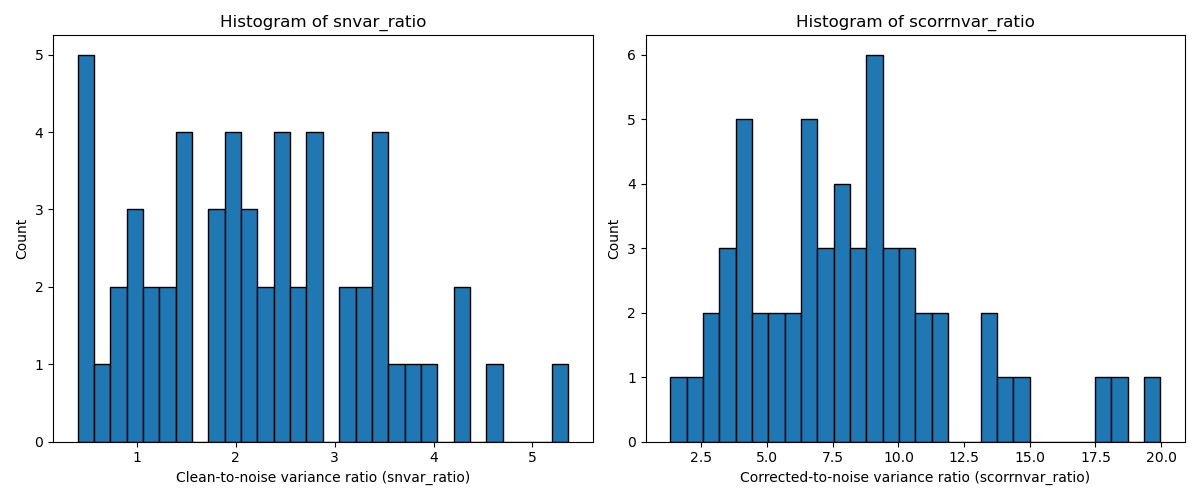

In [6]:

# 1) Extract and flatten
data_sn    = snvar_ratio.values.flatten()
data_scorr = scorrnvar_ratio.values.flatten()

# 2) Create side-by-side subplots
fig, axes = p.subplots(1, 2, figsize=(12, 5))

# 3) Histogram of snvar_ratio
axes[0].hist(data_sn, bins=30, edgecolor="black")
axes[0].set_xlabel("Clean-to-noise variance ratio (snvar_ratio)")
axes[0].set_ylabel("Count")
axes[0].set_title("Histogram of snvar_ratio")

# 4) Histogram of scorrnvar_ratio
axes[1].hist(data_scorr, bins=30, edgecolor="black")
axes[1].set_xlabel("Corrected-to-noise variance ratio (scorrnvar_ratio)")
axes[1].set_ylabel("Count")
axes[1].set_title("Histogram of scorrnvar_ratio")

# 5) Tidy up
p.tight_layout()
p.show()


In [7]:
wdw_s = 10
window_len_samples = int(np.ceil(wdw_s * noise_total_sig.cd.sampling_rate))

## calculates variance over a sliding window of wdw size across the time dimension
# variance of estimated total hp noise
noise_hp_sliding_var = noise_total_sig_hp.rolling(time=window_len_samples, center=True).var()
# variance of cleaned signal (without artifact and est. noise)
sig_clean_hp_sliding_var = sig_clean_hp.rolling(time=window_len_samples, center=True).var()
# variance of corrected signal (without artifacts)
sig_corr_hp_sliding_var = sig_corr_hp.rolling(time=window_len_samples, center=True).var()
# variance of AR residual (estimated noise after motion correction)
ar_filtered_sig_hp_sliding_var = ar_filtered_sig_hp.rolling(time=window_len_samples, center=True).var()

# ratio between artifact corrected signal and AR residual variance
scorrnvar_ratio_sliding = sig_corr_hp_sliding_var/ar_filtered_sig_hp_sliding_var
# ratio between clean signal (without artifacts and est. noise) variance and total noise estimate (AR + artifacts)
snvar_ratio_sliding = sig_clean_hp_sliding_var/noise_hp_sliding_var

# creates a boolean mask for variance/variance threshold
vv_thresh=2
snvar_mask = snvar_ratio_sliding > vv_thresh

scorrnvar_mask =  scorrnvar_ratio_sliding > vv_thresh

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


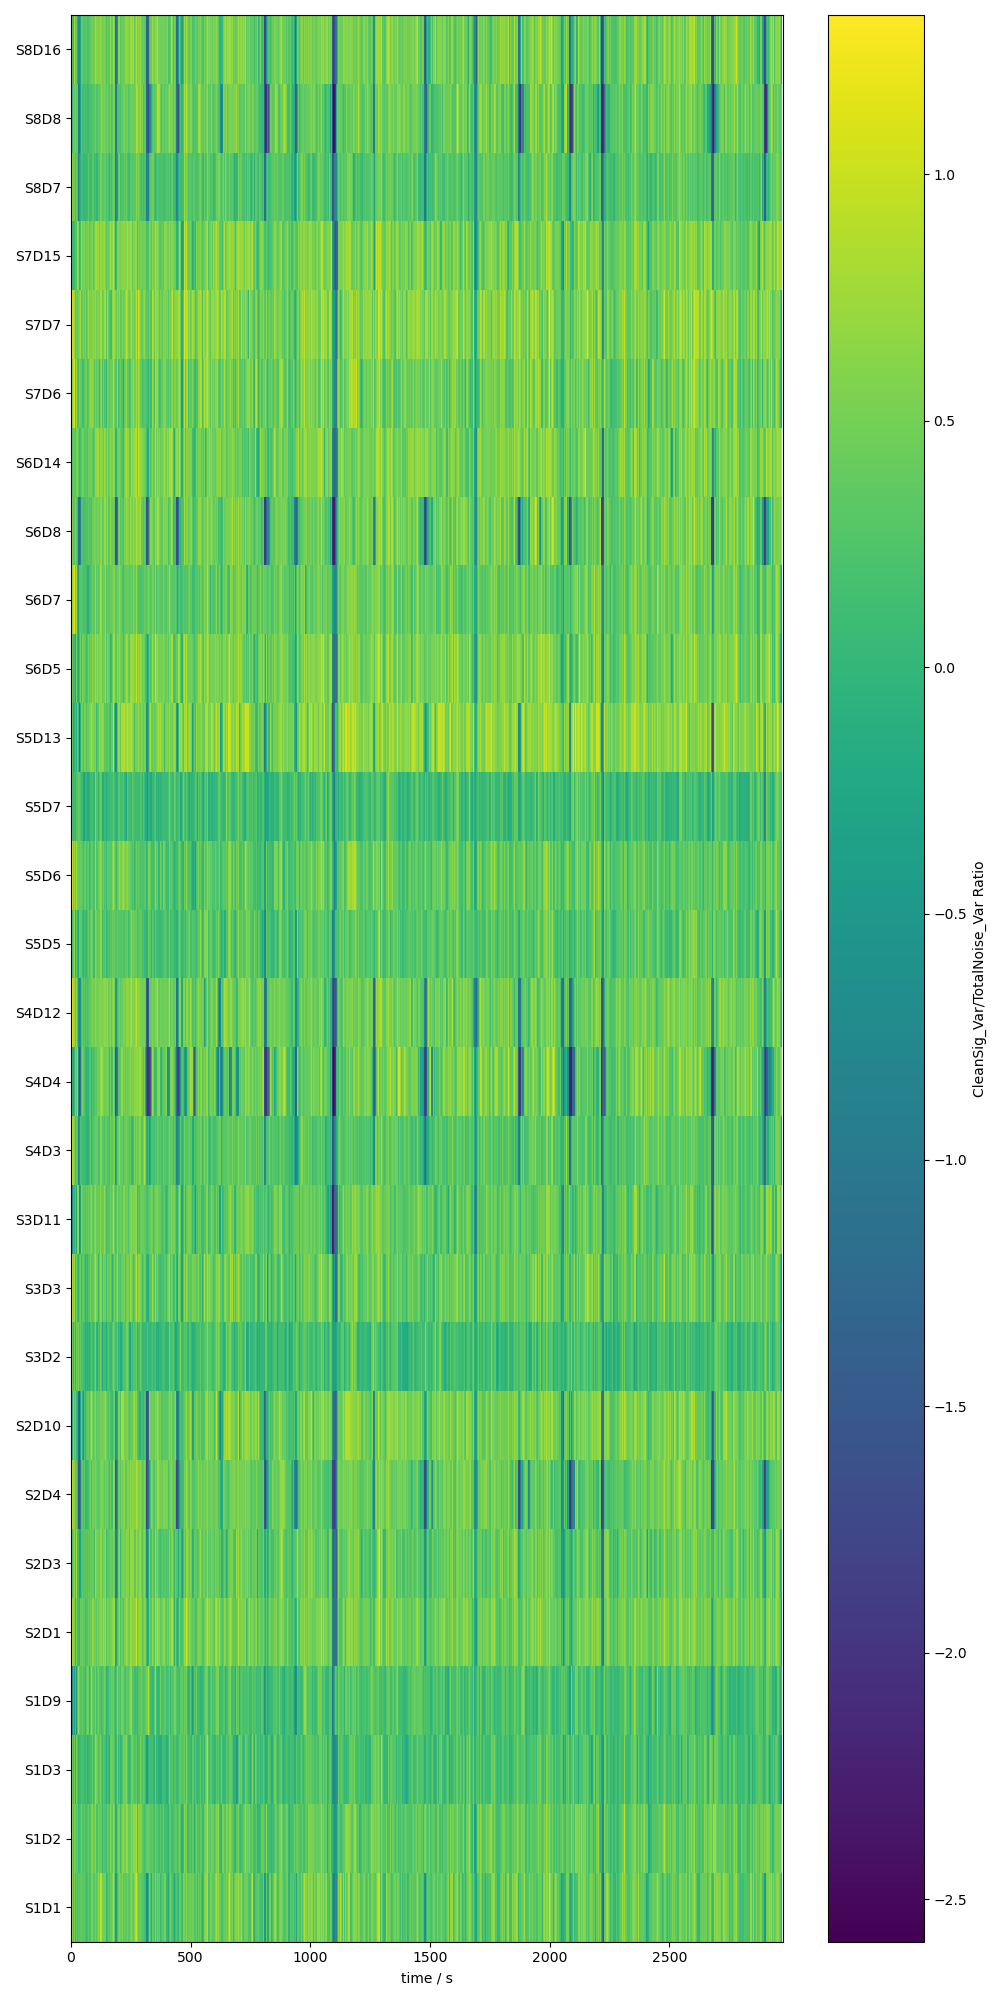

In [8]:
nmetric = np.log10(snvar_ratio_sliding.sel(wavelength=760))

#f,ax = p.subplots(1,1,figsize=(10,60))
f,ax = p.subplots(1,1,figsize=(10,20))

m = ax.pcolormesh(snvar_ratio_sliding.time, np.arange(len(snvar_ratio_sliding.channel)), nmetric, shading="nearest")
cb = p.colorbar(m, ax=ax)
cb.set_label("CleanSig_Var/TotalNoise_Var Ratio")
ax.set_xlabel("time / s")
ax.yaxis.set_ticks(np.arange(len(snvar_ratio_sliding.channel)))
ax.yaxis.set_ticklabels(snvar_ratio_sliding.channel.values)
p.tight_layout()

### Plot Raw and cleaned signal, and estimated noises

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


0.0005792748692970848
3.7683509446956746e-06
3.33533599353452e-06
0.8850916601144418


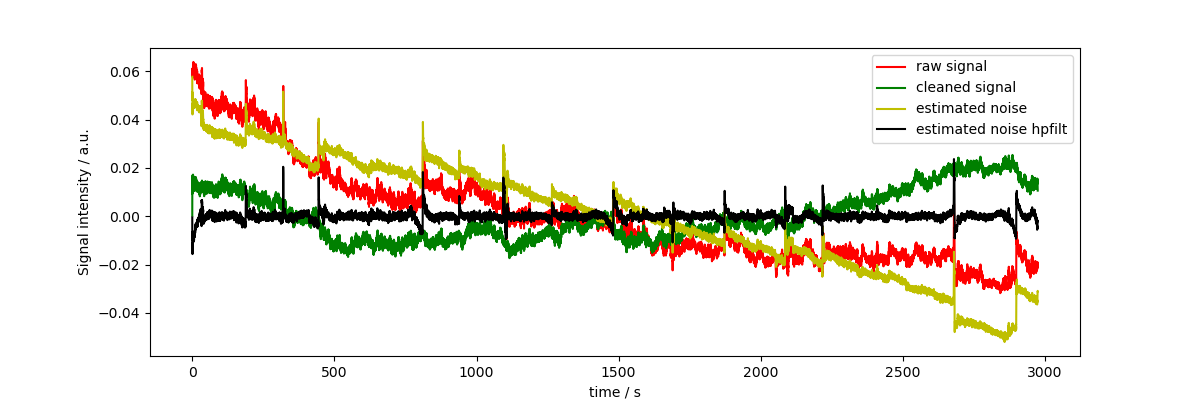

In [9]:
## Finger Tapping Data
#CH = "S5D13"
CH = "S8D16"
#CH = "S8D7"
#CH = "S1D9"
## NN Resting Data
#CH = "S47D115" #!!! saturation test, great outlier
#CH = "S39D61" # !!! saturation ntest, great outlier
#CH = "S43D55"
## DOT data
#CH = "S13D26"  # Example channel, change as needed
dom = "od_clean"
wl = "760"

time = rec["od"].time

f,ax = p.subplots(1,1, figsize=(12,4))
ax.plot( time, rec["od"].sel(channel=CH, wavelength=wl), "r-", label="raw signal")
ax.plot( time, rec[dom].sel(channel=CH, wavelength=wl), "g-", label="cleaned signal")
ax.plot( time, noise_total_sig.sel(channel=CH, wavelength=wl), "y-", label="estimated noise")
ax.plot( time, noise_total_sig_hp.sel(channel=CH, wavelength=wl), "k-", label="estimated noise hpfilt")
p.legend()
ax.set_xlabel("time / s")
ax.set_ylabel("Signal intensity / a.u.")

print(noise_var.sel(channel=CH, wavelength=wl).values)
print(noise_hp_var.sel(channel=CH, wavelength=wl).values)
print(sig_clean_hp_var.sel(channel=CH, wavelength=wl).values)
# ratio between signal variance and noise variance
print(snvar_ratio.sel(channel=CH, wavelength=wl).values)

### Plot Original Signal vs New Metric Var(Noisefree HP Sig)/(Est HP Noise) vs mask from threshold v_sig/v_noise < 1
Normalized by peak of each signal to get to the same scale

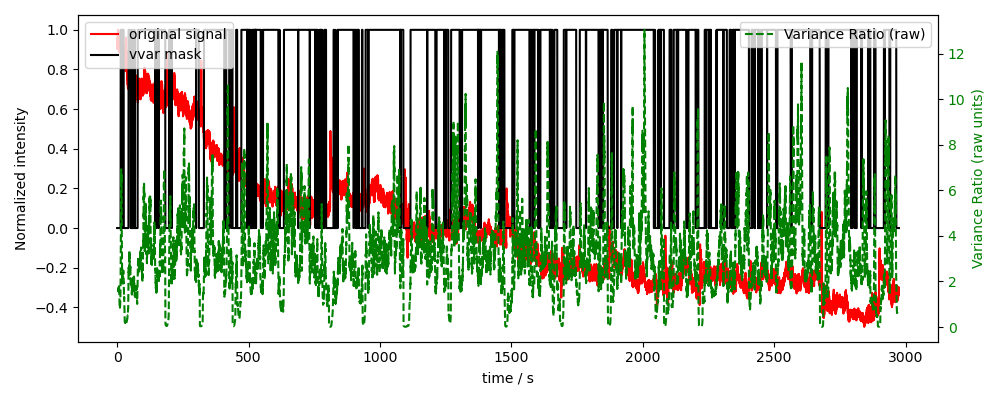

In [10]:
fig, ax1 = p.subplots(figsize=(10, 4))

# — your normalized plots on the left axis —
ax1.plot(rec["od"].time, rec["od"].sel(channel=CH, wavelength=wl) / rec["od"].sel(channel=CH, wavelength=wl).max(), "r-", label="original signal")
ax1.plot(snvar_mask.time, snvar_mask.sel(channel=CH, wavelength=wl), "k-", label="vvar mask" )

ax1.set_xlabel("time / s")
ax1.set_ylabel("Normalized intensity", color="k")
ax1.tick_params(axis="y", labelcolor="k")
ax1.legend(loc="upper left")

# — create a twin for the raw variance ratio —
ax2 = ax1.twinx()
ax2.plot(snvar_ratio_sliding.time, snvar_ratio_sliding.sel(channel=CH, wavelength=wl), "--", color="g", label="Variance Ratio (raw)" )

# force ticks and label on the right
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Variance Ratio (raw units)", color="g")
ax2.tick_params(axis="y", labelcolor="g")
ax2.legend(loc="upper right")

p.tight_layout()
p.show()

### Plot Cleaned Signal vs New Metric Var(Noisefree HP Sig)/(Est HP Noise after artifact cleaning) vs mask from threshold v_sig/v_noise < 1
Normalized by peak of each signal to get to the same scale

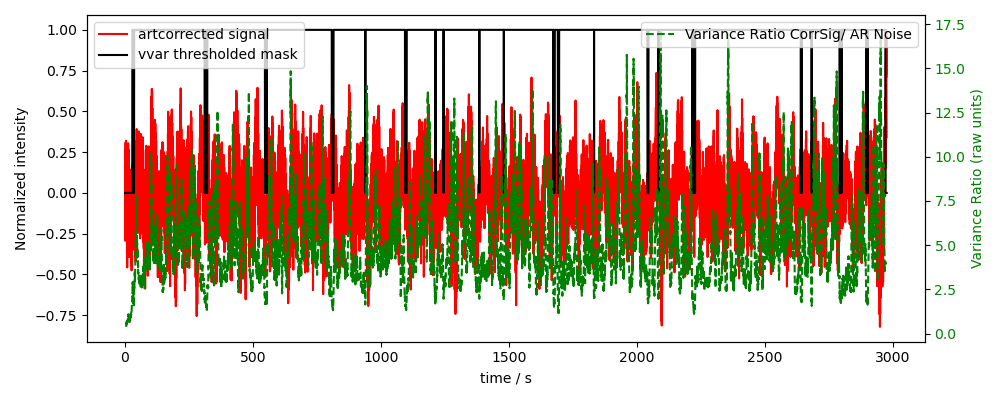

In [11]:
fig, ax1 = p.subplots(figsize=(10, 4))
ax1.plot( sig_corr_hp.time, sig_corr_hp.sel(channel=CH, wavelength=wl)/sig_corr_hp.sel(channel=CH, wavelength=wl).max(), "r-", label="artcorrected signal")
ax1.plot( scorrnvar_mask.time, scorrnvar_mask.sel(channel=CH, wavelength=wl), "k-", label="vvar thresholded mask")
ax2 = ax1.twinx()
ax2.plot(scorrnvar_ratio_sliding.time, scorrnvar_ratio_sliding.sel(channel=CH, wavelength=wl), "--", color="g", label="Variance Ratio CorrSig/ AR Noise" )

# force ticks and label on the right
ax1.set_xlabel("time / s")
ax1.set_ylabel("Normalized intensity", color="k")
ax1.tick_params(axis="y", labelcolor="k")
ax1.legend(loc="upper left")
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Variance Ratio (raw units)", color="g")
ax2.tick_params(axis="y", labelcolor="g")
ax2.legend(loc="upper right")

p.tight_layout()
p.show()


### Calculate C_meas (Measurement Noise Cross-covariance): Without artifact cleaning


In [12]:
# without artifact cleaning (artifacts are considered part of the noise)
X = noise_total_sig_hp.sel(wavelength = "760").values

cov_noise_woac = np.matmul(X, X.T) / (X.shape[1] - 1)
channel_coords = noise_total_sig_hp.channel.values

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


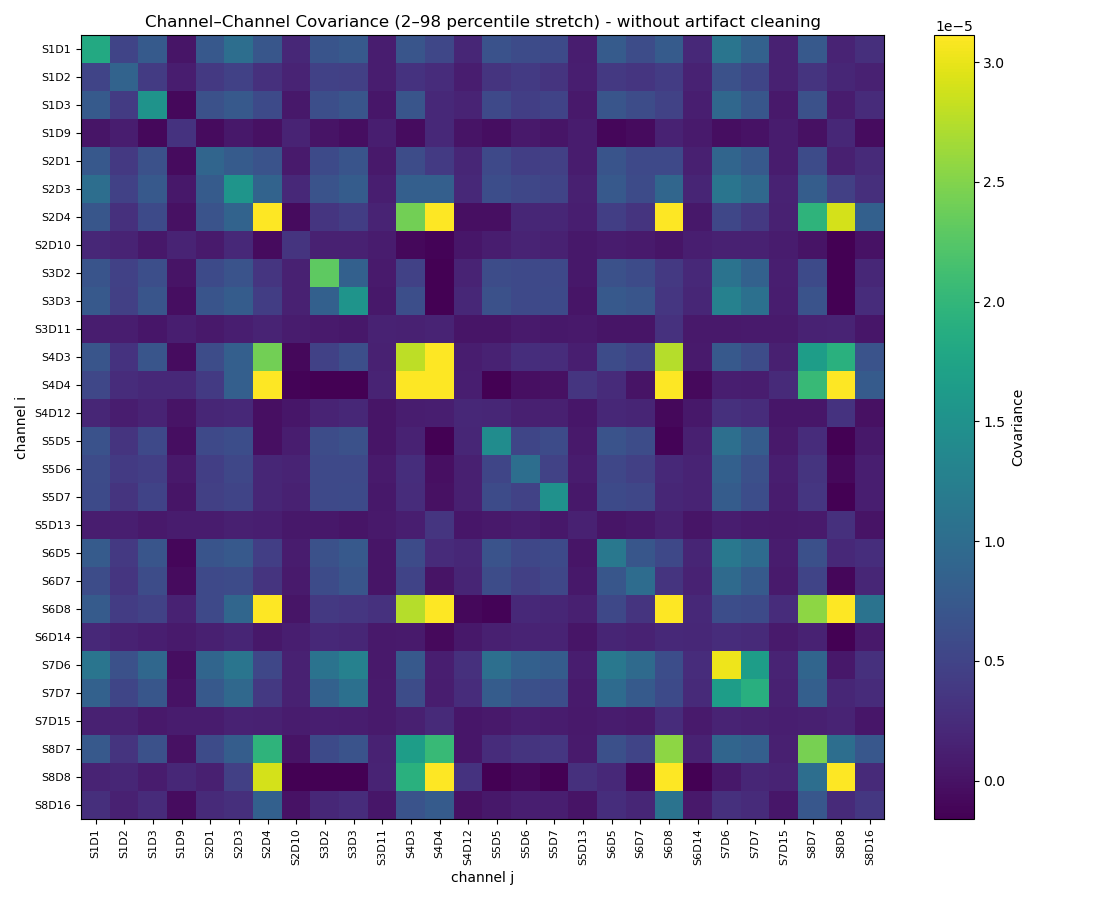

In [13]:

labels = channel_coords  # your array of channel names

# pick the percentiles you want to span (e.g. 2nd and 98th)
p_low, p_high = 2, 98
vmin, vmax = np.percentile(cov_noise_woac, [p_low, p_high])

fig, ax = p.subplots(figsize=(11, 9))

# robust‐scaled heatmap
im = ax.imshow(
    cov_noise_woac,
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)

# ticks & labels
n = len(labels)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticks(np.arange(n))
ax.set_yticklabels(labels, fontsize=8)

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Covariance")

# axes labels and title
ax.set_xlabel("channel j")
ax.set_ylabel("channel i")
ax.set_title(f"Channel–Channel Covariance ({p_low}–{p_high} percentile stretch) - without artifact cleaning")

p.tight_layout()
p.show()


### Calculate C_meas (Measurement Noise Cross-covariance): With artifact cleaning


In [14]:
# without artifact cleaning (artifacts are considered part of the noise)
X = ar_filtered_sig_hp.sel(wavelength = "760").values

cov_noise_wac = np.matmul(X, X.T) / (X.shape[1] - 1)
channel_coords = ar_filtered_sig_hp.channel.values

c:\Users\avonl\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


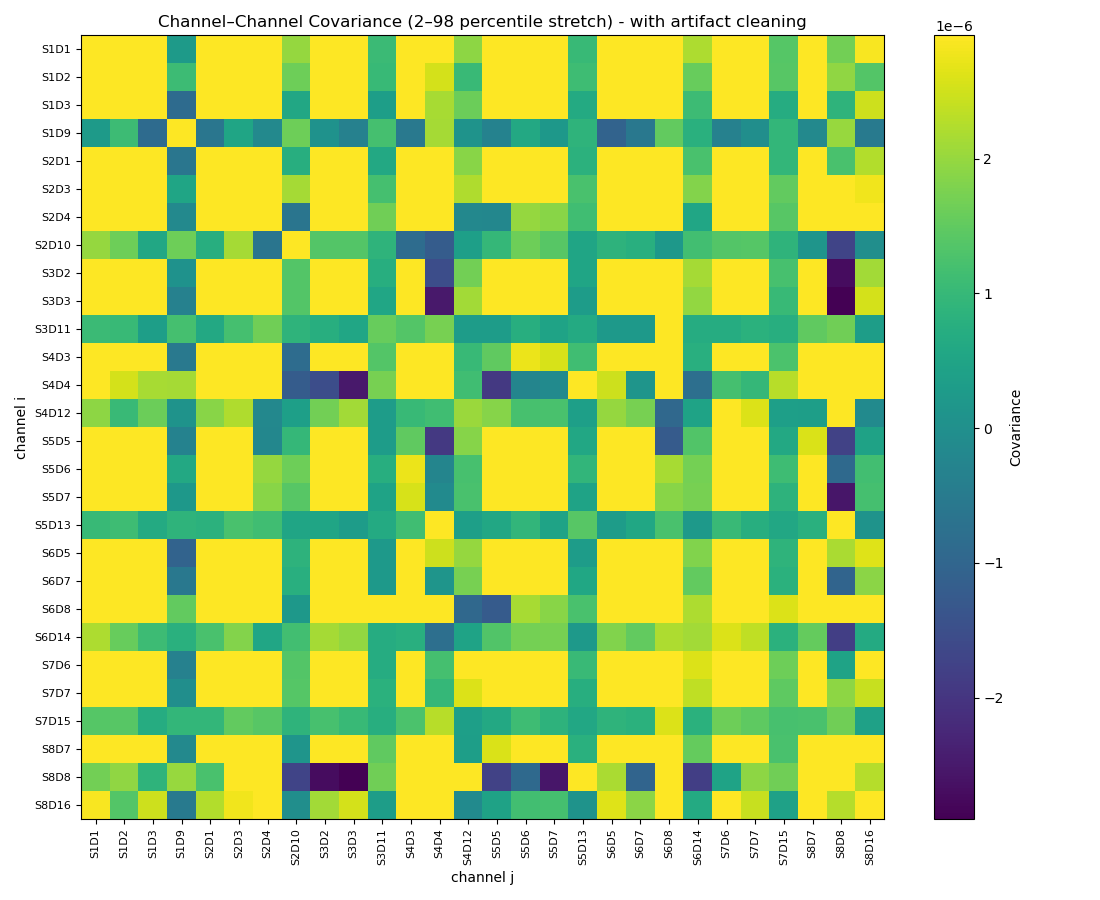

In [15]:

labels = channel_coords  # your array of channel names

# pick the percentiles you want to span (e.g. 2nd and 98th)
p_low, p_high = 2, 98
vmin, vmax = np.percentile(cov_noise_wac, [p_low, p_high])

fig, ax = p.subplots(figsize=(11, 9))

# robust‐scaled heatmap
im = ax.imshow(
    cov_noise_woac,
    aspect="auto",
    cmap="viridis",
    vmin=vmin,
    vmax=vmax,
)

# ticks & labels
n = len(labels)
ax.set_xticks(np.arange(n))
ax.set_xticklabels(labels, rotation=90, fontsize=8)
ax.set_yticks(np.arange(n))
ax.set_yticklabels(labels, fontsize=8)

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Covariance")

# axes labels and title
ax.set_xlabel("channel j")
ax.set_ylabel("channel i")
ax.set_title(f"Channel–Channel Covariance ({p_low}–{p_high} percentile stretch) - with artifact cleaning")

p.tight_layout()
p.show()
